In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

X, y = datasets.make_classification(n_samples=1000, n_classes=3, n_informative=5, n_features=10)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [11]:
class DecisionTree:
    def __init__(self, max_depth=100, min_samples=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
    
    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])
    
    def entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        entr = -np.sum([p * np.log2(p) for p in ps if p > 0])
        gini = np.sum([p * (1 - p) for p in ps])
        return entr
    
    def most_common(self, y):
        labels = np.unique(y)
        count = [list(y).count(i) for i in labels]
        return labels[np.argmax(count)]
    
    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_gain = -1
        
        index = np.random.choice(X.shape[1])
        
        for i in [index]:
            thresholds = np.unique(X[:, i])
            for threshold in thresholds:
                gain = self.information_gain(X[:, i], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold
        return best_feature, best_threshold
    
    def information_gain(self, X_column, y, threshold):        
        if len(np.unique(y)) == 1: 
            return 0
        
        n = len(y)
        parent = self.entropy(y)
        
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()
        
        e_l, n_l = self.entropy(y[left_indexes]), len(left_indexes)
        e_r, n_r = self.entropy(y[right_indexes]), len(right_indexes)
        
        child = (n_l / n) * e_l + (n_r / n) * e_r
        return parent - child
    
    def grow_tree(self, X, y, depth=0):
        n_samples = len(y)
        n_labels = len(np.unique(y))
         
        if n_labels == 1 or depth >= self.max_depth or n_samples <= self.min_samples:
            return Node(value=self.most_common(y))
        
        best_feature, best_threshold = self.best_split(X, y)
        
        left_indexes = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        
        if len(left_indexes) == 0 or len(right_indexes) == 0:
            return Node(value=self.most_common(y))

        left = self.grow_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self.grow_tree(X[right_indexes, :], y[right_indexes], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        if x[tree.feature] < tree.threshold:
            return self.travers_tree(x, tree.left)
        return self.travers_tree(x, tree.right)

In [12]:
class RandomForest:
    def __init__(self, n_trees=3, max_depth=100, min_samples=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.trees = []
        self.n_samples = None
        self.samples = []
        self.oob_samples = []
        self.oob_results = []
        
    def fit(self, X, y):
        self.n_samples = X.shape[0]
        for i in range(self.n_trees):
            samples = np.random.choice(self.n_samples, self.n_samples, replace=True)
            oob_samples = np.array([j for j in range(self.n_samples) if j not in samples])
            
            tree = DecisionTree(max_depth = self.max_depth, min_samples=self.min_samples)
            tree.fit(X[samples, :], y[samples])
            self.oob_results.append(tree.predict(X[oob_samples, :]))
            
            self.trees.append(tree)
            self.samples.append(samples)
            self.oob_samples.append(oob_samples)

    def predict(self, X):
        predictions = []
        for i in range(self.n_trees):
            predictions.append(self.trees[i].predict(X))
        
        predictions = [self.trees[0].most_common(np.array(predictions)[:, i]) for i in range(X.shape[0])]
        
        return predictions
    
    def oob_score(self):
        predictions = np.ones((self.n_trees, self.n_samples)) * np.nan
        
        for i in range(self.n_trees):
            for index, sample in enumerate(self.oob_samples[i]):
                predictions[i, sample] = self.oob_results[i][index]
        
        y_voted = []
        y_real = []
        
        for i in range(self.n_samples):
            oob_y = predictions[np.isnan(predictions[:, i])==False, i]
            if len(oob_y) >= 1:
                y_voted.append(self.trees[0].most_common(oob_y))
                y_real.append(y[i] * 1.0)
        
        return self.score(np.array(y_voted), np.array(y_real))
    
    def score(self, predicted, y):
        return np.sum(predicted == y) / len(y)

In [13]:
clf = RandomForest()
clf.fit(X_train, y_train)

In [14]:
clf.oob_score()

0.35583941605839414

In [15]:
test_score = []
train_score = []
oob_score = []
n_trees = []

for i in tqdm(range(3, 203, 20)):
    clf = RandomForest(n_trees=i)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(clf.predict(X_train), y_train))
    test_score.append(clf.score(clf.predict(X_test), y_test))
    oob_score.append(clf.oob_score())
    
    n_trees.append(i)

100%|██████████| 10/10 [15:31<00:00, 93.13s/it] 


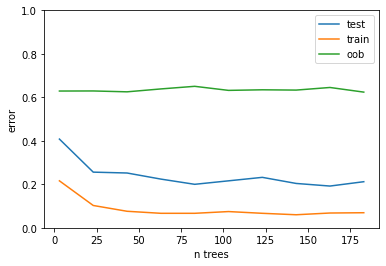

In [21]:
plt.plot(n_trees, 1 - np.array(test_score), label="test")
plt.plot(n_trees, 1 - np.array(train_score), label="train")
plt.plot(n_trees, 1 - np.array(oob_score), label="oob")

plt.legend()
plt.ylabel("error")
plt.xlabel("n trees")
plt.ylim(0, 1)
plt.savefig("accuracy.png")
plt.show()